In [29]:
# import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.utils.np_utils import to_categorical

import os

In [15]:
batch_size = 1

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../data/cross_circles/scaled/s64_1/train/',  # this is the target directory
        target_size=(64, 64),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary',color_mode='grayscale')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../data/cross_circles/scaled/s64_1/test/',
        target_size=(64,64),
        batch_size=batch_size,
        class_mode='binary',color_mode='grayscale')


Found 172 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


### Model

In [20]:
model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    
model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
    
model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1, activation='softmax'))
    
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [21]:
model.fit_generator(
        train_generator,
        steps_per_epoch=172 // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=80 // batch_size)
model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/10
172/172 [==============================] - 12s 63ms/step - loss: 0.6934 - accuracy: 0.5041 - val_loss: 0.7551 - val_accuracy: 0.5000
Epoch 2/10
 92/172 [===============>..............] - ETA: 4s - loss: 0.6933 - accuracy: 0.5148

KeyboardInterrupt: 

## Circle Detection

In [23]:
import cv2
import numpy as np
  
# Read image.
img = cv2.imread('../data/cross_circles/scaled/s256/circles/b_c_1.jpg', cv2.IMREAD_COLOR)
  
# Convert to grayscale.
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
# Blur using 3 * 3 kernel.
gray_blurred = cv2.blur(gray, (3, 3))
  
# Apply Hough transform on the blurred image.
detected_circles = cv2.HoughCircles(gray_blurred, 
                   cv2.HOUGH_GRADIENT, 1, 20, param1 = 50,
               param2 = 30, minRadius = 1, maxRadius = 40)
  
# Draw circles that are detected.
if detected_circles is not None:
  
    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(np.around(detected_circles))
  
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
  
        # Draw the circumference of the circle.
        cv2.circle(img, (a, b), r, (0, 255, 0), 2)
  
        # Draw a small circle (of radius 1) to show the center.
        cv2.circle(img, (a, b), 1, (0, 0, 255), 3)
        cv2.imshow("Detected Circle", img)
        cv2.waitKey(0)

### Closed Contours

In [51]:
img = cv2.imread('../data/cross_circles/scaled/s64/circles/b_c_1.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [52]:
contours, hierarchy  = cv2.findContours(img_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [53]:
closed_contours = []
open_contours = []
for i in contours:
    if cv2.contourArea(i) > cv2.arcLength(i, True):
        closed_contours.append(i)
    else:
        open_contours.append(i)

In [54]:
closed_contours

[array([[[ 0,  0]],
 
        [[ 0, 63]],
 
        [[63, 63]],
 
        [[63,  0]]], dtype=int32)]

In [60]:
closed_contours[0][1][0][1]

63

In [66]:
cv2.circle(img, (closed_contours[0][0][0][0],closed_contours[0][0][0][1]), radius=2, color=(0, 0, 255), thickness=5)
cv2.circle(img, (63,63), radius=5, color=(0, 0, 255), thickness=5)

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [141, 141, 141],
        [142, 142, 142],
        [144, 144, 144]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [144, 144, 144],
        [142, 142, 142],
        [143, 143, 143]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [142, 142, 142],
        [143, 143, 143],
        [144, 144, 144]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [144, 144, 144]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [142, 142, 142],
        [144, 144, 144]]

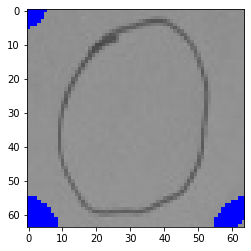

In [67]:
plt.imshow(img)